In [ ]:
import os
import torch
import torch.utils.data
import torchvision
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from torchvision import transforms as T

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

In [ ]:
from pathlib import Path


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # filename for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # filename of input mask corresponding to the above image file
        mask_file_path = os.path.splitext(path)[0] + '.png'
        # open the input image
        img = Image.open(os.path.join(self.root, 'images',path)).convert('RGB')
        ## mask ##
        mask = Image.open(os.path.join(self.root,'masks',mask_file_path))
        # convert the PIL Image of mask into a numpy array
        # mask = np.array(mask)
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        iscrowd = []
        labels = []

        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
            iscrowd.append(coco_annotation[i]['iscrowd'])
            labels.append(coco_annotation[i]['category_id'])

        areas,iscrowd,labels = map(torch.tensor, [areas,iscrowd,labels])
        
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
        mask = mask.numpy().reshape(mask.shape,order='F')
        mask = torch.as_tensor(mask, dtype=torch.uint8)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation["masks"] = mask
        
        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def get_transform(train):
    custom_transforms = []
   # if train:
   #     custom_transforms.append(T.RandomHorizontalFlip(0.5))
    custom_transforms.append(T.ToTensor())
    return T.Compose(custom_transforms)

In [ ]:
def process_data(loc):
  path = Path(loc)
  data_dir = path
  coco_instances = path/'coco_instances.json'
  # create own Dataset
  my_dataset = myOwnDataset(root=data_dir,
                            annotation=coco_instances,
                            transforms=get_transform(train=True)) 
  #Category dictinoray for output tagging
  instances = COCO(coco_instances)
  categories = instances.loadCats(instances.getCatIds())
  class_dict = {d['id']:d['name'] for d in categories}
  #print(class_dict)
  
  return my_dataset, class_dict, instances

In [ ]:
!pip install pytorch_lightning

In [ ]:
import pytorch_lightning as pl  


In [ ]:
class DataModulesemantic(pl.LightningDataModule):
  def __init__(self,my_dataset):
    super(DataModulesemantic,self).__init__()
    self.bs=10
    self.my_dataset=my_dataset
    samples = len(my_dataset)
    test_counts = int(samples*.2)
    train_counts = samples-test_counts
    self.train_set, self.val_set = torch.utils.data.random_split(self.my_dataset, [train_counts, test_counts])
    #self.train_set, self.val_set = train_set, val_set #, self.class_dict, self.instances = process_data(self.loc)
    # loading data using Dataloader: Train, val and test
    def collate_fn(batch):
      return tuple(zip(*batch))
    self.collate_fn=collate_fn  
  def train_dataloader(self):
    return DataLoader(self.train_set,batch_size=self.bs,shuffle=False,collate_fn=self.collate_fn)
  def val_dataloader(self):
    return DataLoader(self.val_set,batch_size=self.bs,shuffle=False,collate_fn=self.collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    ## model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
class FCNHead_model(pl.LightningModule):
  def __init__(self,num_classes):
    super(FCNHead_model,self).__init__()
    #self.save_hyperparamters()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    self.num_classes=num_classes
    #model=get_model_instance_segmentation(num_classes)
    self.model=get_model_instance_segmentation(self.num_classes)
    self.model.to(device)
    #self.model=model
    # self.criterion = nn.CrossEntropyLoss()
    self.params = [p for p in self.model.parameters() if p.requires_grad]


    #self.optimizer = torch.optim.Adadelta(params, lr=1e-4)
  def configure_optimizers(self): # specifying optimizer and learning rate
    return torch.optim.SGD(self.params, lr=0.005, momentum=0.08)

  # def forward(x):
  #   return model(x)    

    # Training , validating and testing phase with lightening method
  def training_step(self, train_batch,batch_idx):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    imgs, annotations  = train_batch
    imgs = list(img.to(device) for img in imgs)
    annotations = [{key: value.to(device) for key, value in annotation.items()} for annotation in annotations]
    loss_dict = self.model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())
    return losses 
  # def vaildation_step(self, valid_batch, batch_idx):
  #   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #   imgs, annotations  = valid_batch
  #   imgs = list(img.to(device) for img in imgs)
  #   annotations = [{key: value.to(device) for key, value in annotation.items()} for annotation in annotations]
  #   loss_dict = self.model(imgs, annotations)
  #   losses = sum(loss for loss in loss_dict.values())
  #   return losses

In [ ]:
my_dataset, class_dict, instances = process_data('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data') # process data get the files needed


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
%cd '/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data'

/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data


In [ ]:
num_classes = 1 + len(instances.getCatIds())
data_module = DataModulesemantic(my_dataset)
model_module = FCNHead_model(num_classes)
gpu=1 if torch.cuda.is_available() else 0 
trainer = pl.Trainer(max_epochs=1,gpus=gpu)#callbacks=model_checkpoint) 
trainer.fit(model_module, data_module) # fit model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | MaskRCNN | 43.9 M
-----------------------------------
43.7 M    Trainable params
222 K     Non-trainable params
43.9 M    Total params
175.711   Total estimated model params size (MB)


1

In [ ]:
trainer.save_checkpoint("semanticseg.ckpt")

In [ ]:
new_model = FCNHead_model.load_from_checkpoint(num_classes=num_classes,checkpoint_path="semanticseg.ckpt")

In [ ]:
'''
def train_model(epochs, my_dataset, instances):
  # set default epochs to 10 if not set
  max_epoc= 10 if epochs is None else epochs
  #my_dataset, class_dict, instances = self.my_dataset, self.class_dict, self.instances  #process_data(path) # process data get the files needed
  num_classes = 1 + len(instances.getCatIds())
  #model=get_model_instance_segmentation(num_classes)
  #model=create_model(classes) # create model woth 
  data_module = DataModulesemantic(my_dataset) # pass to mentioned class
  model_module = FCNHead_model(num_classes)
  gpu=1 if torch.cuda.is_available() else 0 # setting gpu based on availability
  #model_dir = os.getcwd() + '/loglogs'
  #model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="train_loss",dirpath=model_dir)
  #checkpoint_callback = ModelCheckpoint(monitor='train_loss')
  trainer = pl.Trainer(max_epochs=max_epoc,gpus=gpu)#callbacks=model_checkpoint) 
  trainer.fit(model_module, data_module) # fit model
  #trainer.test() # test
  return checkpoint_callback #model #

 ''' 

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
#print('hello')

In [ ]:
#train_model(1,'/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/')

In [ ]:

def get_prediction(img_path, new_model,threshold,class_dict):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = img.to(device) #cuda()
    model=new_model
    model=model.to(device)
    model=model.eval()
    pred = model([img])
    print('pred: ',pred)
    pred_score = list(pred[0]['scores'].detach().to('cpu').numpy())
    print('pred_score: ',pred_score)
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    print('pred_t:',pred_t)
    
    masks = (pred[0]['masks']>0.5).squeeze().detach().to('cpu').numpy()
    print('masks:',masks)
    print('masks shape from output: ', pred[0]['masks'].shape)
    pred_class = [class_dict[i] for i in list(pred[0]['labels'].detach().to('cpu').numpy())]
    print('pred_class: ',pred_class)
    
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().to('cpu').numpy())]
    print('pred_boxes: ',pred_boxes)
    masks = masks[:pred_t+1]
    #print('masks with threshold:',masks)
    pred_boxes = pred_boxes[:pred_t+1]
    print('pred_boxes:',pred_boxes)
    pred_class = pred_class[:pred_t+1]
    print('pred_class: ',pred_class)
    return masks, pred_boxes, pred_class

In [ ]:
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [ ]:
def instance_segmentation_api(img_path,new_model,class_dict, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    #class_dict=class_dict
    masks, boxes, pred_cls = get_prediction(img_path,new_model,threshold,class_dict)
    print(masks.shape)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return None

In [ ]:
instance_segmentation_api('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/images/00000000.png',new_model,class_dict, threshold=0.1)


NotImplementedError: ignored

In [ ]:
class semantic():
  def load_model(self,path):
    self.path=path
    self.my_dataset, self.class_dict, self.instances = process_data(self.path) # process data get the files needed
    #self.classes,self.images,self.path1=process_data(self.path)
  def train(self,epochs):
    self.epochs=epochs
    self.model=train_model(self.epochs,self.my_dataset, self.instances )
  def predict(self,image):
    self.img_path=image
    instance_segmentation_api(self.img_path,self.model ,self.class_dict, threshold=0.1, rect_th=3, text_size=3, text_th=3)
    #predict_img(self.image,self.model)

In [ ]:
%cd '/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data'

/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data


In [ ]:
apple=semantic()
apple.load_model('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
apple.train(1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | MaskRCNN | 43.9 M
-----------------------------------
43.7 M    Trainable params
222 K     Non-trainable params
43.9 M    Total params
175.711   Total estimated model params size (MB)


pred:  [{'boxes': tensor([[2.8752e+02, 1.0126e+02, 4.7891e+02, 5.5873e+02],
        [2.7957e+02, 5.8594e+01, 7.8872e+02, 5.6879e+02],
        [2.4203e+02, 1.6618e+01, 3.8906e+02, 5.3210e+02],
        [2.0781e+02, 3.2297e-01, 4.7961e+02, 6.7347e+02],
        [3.3184e+02, 2.3886e+02, 6.3806e+02, 5.7441e+02],
        [2.7226e+02, 2.1548e+02, 4.3173e+02, 6.2650e+02],
        [1.9685e+02, 9.5852e+01, 5.2530e+02, 7.3234e+02],
        [2.1537e+02, 6.8166e+01, 4.9192e+02, 3.9228e+02],
        [2.5798e+02, 3.1707e+02, 5.3210e+02, 6.4003e+02],
        [1.5257e+02, 6.5769e+01, 5.0460e+02, 4.1932e+02],
        [3.9479e+02, 1.2278e+02, 7.1715e+02, 4.4692e+02],
        [1.5659e+02, 1.8720e+02, 7.6492e+02, 5.5172e+02],
        [1.6854e+02, 8.7883e+01, 8.2030e+02, 4.3543e+02],
        [2.1007e+02, 2.3652e+02, 7.3220e+02, 6.9026e+02],
        [2.2872e+02, 1.5522e+02, 4.6733e+02, 4.3408e+02],
        [6.1868e+01, 1.2201e+02, 7.2769e+02, 7.2702e+02],
        [2.0795e+02, 2.3129e+01, 3.8295e+02, 4.4646e+0

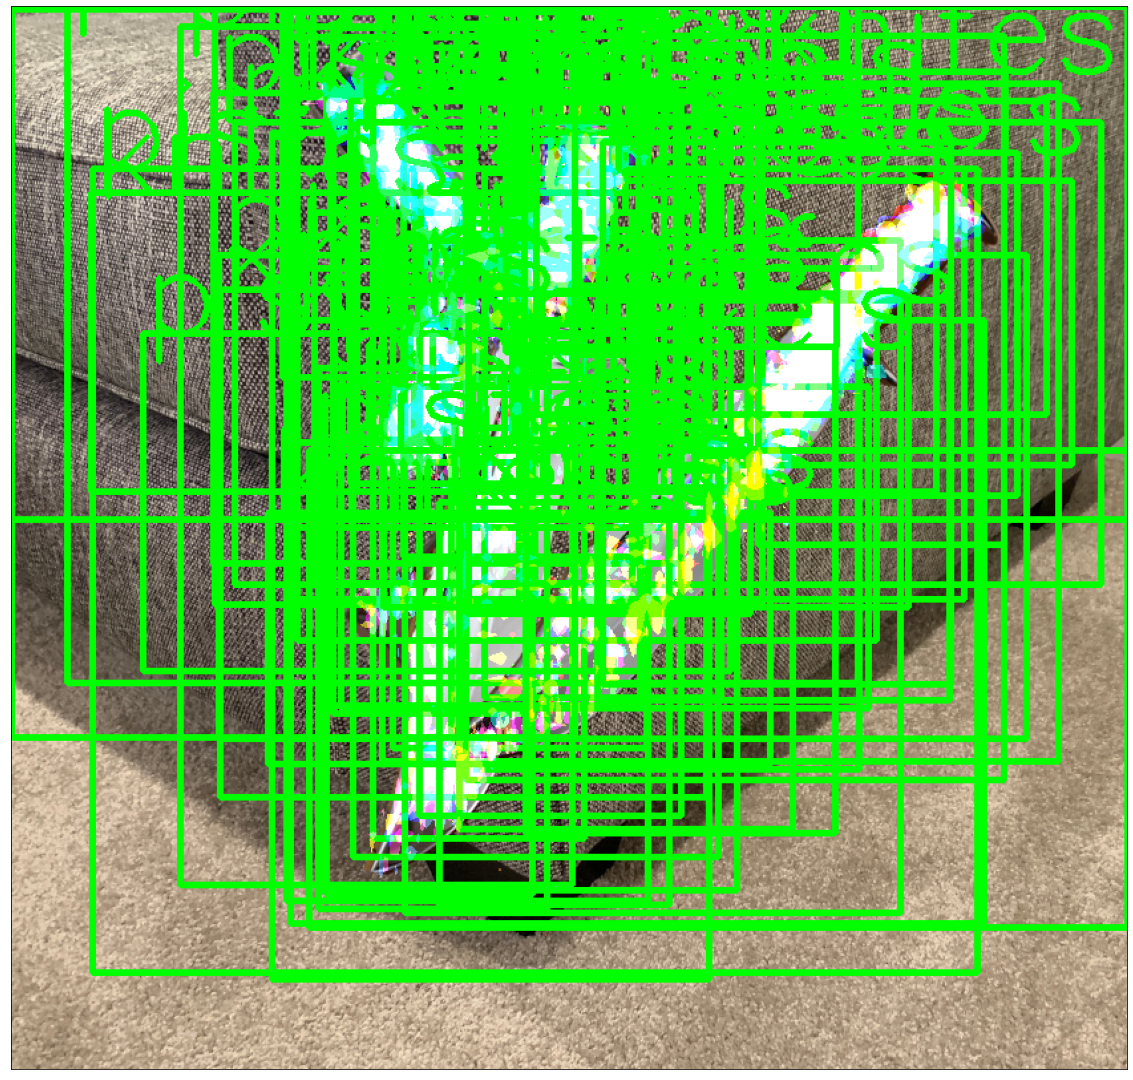

In [ ]:
apple.predict('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/images/00000000.png')